In [64]:
import time
import warnings

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from mpmath.math2 import math_sqrt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, LearningCurveDisplay
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

In [66]:
df = pd.read_parquet('../data/cleaned_data.parquet')
df.head()

,stationcode,name,is_installed,capacity,numdocksavailable,numbikesavailable,mechanical,ebike,is_renting,is_returning,duedate,coordonnees_geo,nom_arrondissement_communes,code_insee_commune,temperature_2m,precipitation,rain,snowfall,relative_humidity_2m,is_holiday,hour,month,dayofweek,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,bikes_ratio,docks_ratio
0,6108,Saint-Romain - Cherche-Midi,OUI,17.0,11,6,5,1,OUI,OUI,2024-10-19 15:38:59+00:00,"[48.84708159081946, 2.321374788880348]",Paris,75056,16.35,0.0,0.0,0.0,80.83164,1,15,10,5,1,-0.707107,-0.707107,-0.974928,-0.222521,0.352941,0.647059
1,9020,Toudouze - Clauzel,OUI,21.0,13,7,4,3,OUI,OUI,2024-10-19 15:39:51+00:00,"[48.87929591733507, 2.3373600840568547]",Paris,75056,16.35,0.0,0.0,0.0,80.83164,1,15,10,5,1,-0.707107,-0.707107,-0.974928,-0.222521,0.333333,0.619048
2,9020,Toudouze - Clauzel,OUI,21.0,13,7,4,3,OUI,OUI,2024-10-19 15:39:51+00:00,"[48.87929591733507, 2.3373600840568547]",Paris,75056,16.35,0.0,0.0,0.0,80.83164,1,15,10,5,1,-0.707107,-0.707107,-0.974928,-0.222521,0.333333,0.619048
3,14111,Cassini - Denfert-Rochereau,OUI,25.0,21,2,1,1,OUI,OUI,2024-10-19 15:40:10+00:00,"[48.837525839067, 2.3360354080796]",Paris,75056,16.35,0.0,0.0,0.0,80.83164,1,15,10,5,1,-0.707107,-0.707107,-0.974928,-0.222521,0.080000,0.840000
4,15202,Bracion - Périphérique,OUI,30.0,26,4,1,3,OUI,OUI,2024-10-19 15:41:30+00:00,"[48.826103771275, 2.3004549373748]",Paris,75056,16.35,0.0,0.0,0.0,80.83164,1,15,10,5,1,-0.707107,-0.707107,-0.974928,-0.222521,0.133333,0.866667


In [67]:
targets = ['numbikesavailable', 'numdocksavailable']

# On retire les colonnes brutes (dates, IDs, targets) et celles encodées autrement
drop_cols = ['duedate', 'numbikesavailable', 'numdocksavailable', 'nom_arrondissement_communes','is_returning', 'coordonnees_geo', 'is_renting', 'is_installed', 'code_insee_commune']

# Features numériques et catégorielles
categorical_features = ['is_weekend']  # + 'nom_arrondissement' si pertinent
numeric_features = [col for col in df.columns
                    if col not in drop_cols + targets + categorical_features]

X = df.drop(columns=drop_cols + targets)
# Note : on garde X aligné, on sélectionnera les colonnes via ColumnTransformer
y = df[targets]

# --- SPLIT TEMPOREL ---
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTrain set : {X_train.shape}")
print(f"Test set  : {X_test.shape}")


Train set : (141924, 21)
Test set  : (35482, 21)


In [68]:
categorical_features = X.select_dtypes(include=["object", "category"]).columns
categorical_features

Index(['stationcode', 'name'], dtype='object')

In [69]:
numeric_features = X.select_dtypes(exclude=['object']).columns


def create_preprocessor(num_features, cat_features):
    numeric_transformer = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ("imputer", SimpleImputer(strategy="median"))
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]
    )

    pipeline = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features),
        ]
    )

    return pipeline

In [70]:
preprocessor = create_preprocessor(numeric_features, categorical_features)

catboost = CatBoostRegressor(loss_function='MultiRMSE', verbose=None)

xgb = MultiOutputRegressor(XGBRegressor(verbose=None))

lgbm = MultiOutputRegressor(LGBMRegressor(verbose=None))

random_forest = RandomForestRegressor(verbose=0)

models = {
    "CatBoost": catboost,
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "RandomForest": random_forest
}

In [23]:
for key, model in models.items():
    start = time.time()
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)

    elapsed = time.time() - start
    print(f"{key}: R2 Moyen = {scores.mean():.4f} (+/- {scores.std():.4f}) - Temps: {elapsed:.1f}s")

0:	learn: 16.0755224	total: 70.2ms	remaining: 1m 10s
1:	learn: 15.6394773	total: 101ms	remaining: 50.6s
2:	learn: 15.2164535	total: 126ms	remaining: 42s
3:	learn: 14.8058456	total: 143ms	remaining: 35.7s
4:	learn: 14.4055215	total: 171ms	remaining: 33.9s
5:	learn: 14.0231240	total: 206ms	remaining: 34.1s
6:	learn: 13.6466795	total: 228ms	remaining: 32.4s
7:	learn: 13.2864950	total: 256ms	remaining: 31.7s
8:	learn: 12.9299991	total: 272ms	remaining: 29.9s
9:	learn: 12.5905272	total: 304ms	remaining: 30.1s
10:	learn: 12.2570049	total: 328ms	remaining: 29.5s
11:	learn: 11.9318394	total: 353ms	remaining: 29.1s
12:	learn: 11.6156305	total: 377ms	remaining: 28.6s
13:	learn: 11.3100825	total: 397ms	remaining: 28s
14:	learn: 11.0122491	total: 422ms	remaining: 27.7s
15:	learn: 10.7297187	total: 439ms	remaining: 27s
0:	learn: 16.5017280	total: 110ms	remaining: 1m 50s
16:	learn: 10.4485031	total: 459ms	remaining: 26.5s
17:	learn: 10.1738313	total: 478ms	remaining: 26.1s
1:	learn: 16.0575337	total

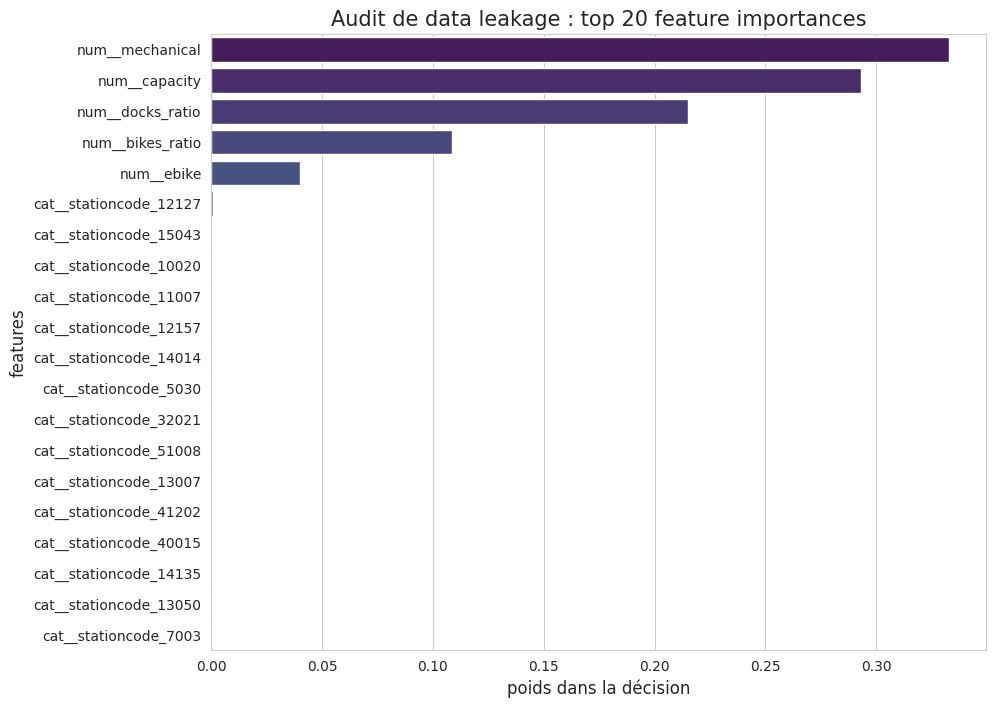


--- TOP 10 VARIABLES SUSPECTES ---
                    Feature  Importance
1           num__mechanical    0.333115
0             num__capacity    0.293312
18         num__docks_ratio    0.215006
17         num__bikes_ratio    0.108748
2                num__ebike    0.039856
202  cat__stationcode_12127    0.000883
382  cat__stationcode_15043    0.000219
37   cat__stationcode_10020    0.000185
94   cat__stationcode_11007    0.000176
211  cat__stationcode_12157    0.000160


In [71]:
# Choix final : XGBoost
# Performance : C'est le meilleur score ($R^2 = 0.9982$), même si la différence est minime.
# Vitesse : C'est le plus rapide (6.3s).
# Efficacité : Comparé au RandomForest (684s), XGBoost est 100 fois plus rapide pour un résultat légèrement meilleur.


xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

xgb_pipeline.fit(X_train, y_train)

# Extraction des noms des features
try:# 6. Visualisation
    feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    feature_names = X_train.columns

# Extraction des importances
multi_output_model = xgb_pipeline.named_steps['model']
importances_per_target = [est.feature_importances_ for est in multi_output_model.estimators_]

# On fait la moyenne des importances sur toutes les cibles
mean_importances = np.mean(importances_per_target, axis=0)

# Création du DataFrame pour l'affichage
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
# On affiche le Top 20 pour la lisibilité
sns.barplot(x='Importance', y='Feature', data=df_imp.head(20), palette='viridis')
plt.title('Audit de data leakage : top 20 feature importances', fontsize=15)
plt.xlabel('poids dans la décision', fontsize=12)
plt.ylabel('features', fontsize=12)
plt.show()

# Affichage textuel du Top 10 pour vérification immédiate
print("\n--- TOP 10 VARIABLES SUSPECTES ---")
print(df_imp.head(10))

In [72]:
leakage_cols = [
    'bikes_ratio',
    'docks_ratio',
    'mechanical',
    'ebike',
    'fill_rate'
]

# Récupérez vos listes de features initiales (Numeric et Categorical)
all_columns = X_train.columns.tolist()

# Filtrage : On garde tout ce qui n'est PAS dans la liste noire
features_to_keep = [c for c in all_columns if c not in leakage_cols]

numeric_features_clean = X_train[features_to_keep].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_clean = X_train[features_to_keep].select_dtypes(
    include=['object', 'category', 'bool']).columns.tolist()

new_preprocessor = create_preprocessor(numeric_features_clean, categorical_features_clean)

# 4. Création du nouveau Pipeline
pipeline_clean = Pipeline(steps=[
    ('preprocessor', new_preprocessor),
    ('model', xgb)
])

# Entraînement sur les données propres (en supprimant les colonnes du DF aussi pour être cohérent)
X_train_clean = X_train[features_to_keep]

scores = cross_val_score(pipeline_clean, X_train_clean, y_train, cv=3, scoring='r2', n_jobs=-1)

print(f"\nNouveau score R2 : {scores.mean():.4f} (+/- {scores.std():.4f})")


Nouveau score R2 : 0.4314 (+/- 0.0117)


In [77]:
def objective(trial):
    hyper_params = {
        "n_estimators": trial.suggest_int("n_estimators", 600, 800),
        "max_depth": trial.suggest_int("max_depth", 7, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.2, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 9),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 20, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 40, 70),
        "subsample": trial.suggest_float("subsample", 0.5, 0.8),
        "gamma": trial.suggest_float("gamma", 7, 9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**hyper_params, device='gpu')

    pipeline = Pipeline(
        steps=[
            ('preprocessor', new_preprocessor),
            ('model', model)
        ]
    )

    pipeline.fit(X_train_clean, y_train)

    y_pred = pipeline.predict(X_test_clean)

    return r2_score(y_test, y_pred)

In [78]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, n_jobs=1)

best_params = study.best_params
best_params

[I 2025-12-27 22:47:29,455] A new study created in memory with name: no-name-fa4027b2-981d-4936-a0e5-643c6ac03082
[I 2025-12-27 22:48:01,534] Trial 0 finished with value: 0.6634213328361511 and parameters: {'n_estimators': 794, 'max_depth': 10, 'learning_rate': 0.24078003001455334, 'min_child_weight': 6, 'reg_lambda': 1.2587221309216339, 'reg_alpha': 54.47285866315652, 'subsample': 0.7799273534840077, 'gamma': 7.3634407423921955, 'colsample_bytree': 0.9078397035000503}. Best is trial 0 with value: 0.6634213328361511.
[I 2025-12-27 22:48:27,522] Trial 1 finished with value: 0.6551800966262817 and parameters: {'n_estimators': 746, 'max_depth': 9, 'learning_rate': 0.26926471661865486, 'min_child_weight': 7, 'reg_lambda': 5.093376624928647, 'reg_alpha': 68.89391817413788, 'subsample': 0.6464720214430448, 'gamma': 7.774689302857553, 'colsample_bytree': 0.9147357231917458}. Best is trial 0 with value: 0.6634213328361511.
[I 2025-12-27 22:48:54,500] Trial 2 finished with value: 0.652175068855

{'n_estimators': 726,
 'max_depth': 10,
 'learning_rate': 0.28876155925498137,
 'min_child_weight': 5,
 'reg_lambda': 1.1782064739935973,
 'reg_alpha': 42.43104847618814,
 'subsample': 0.6524944980912404,
 'gamma': 7.369676564762332,
 'colsample_bytree': 0.8601562209903312}

R2 0.6717262268066406
MSE 40.62916946411133
RMSE 6.374101463273967
MAE 4.886665344238281


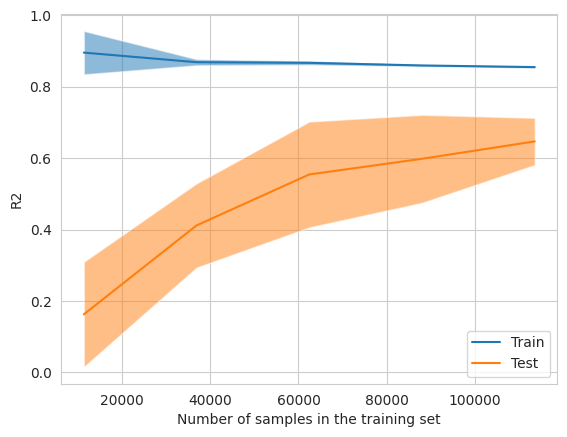

In [79]:
final_model = XGBRegressor(**best_params, device='gpu', verbosity=1, random_state=42)
X_test_clean = X_test[features_to_keep]

pipeline = Pipeline(
    steps=[
        ('preprocessor', new_preprocessor),
        ('model', final_model)
    ]
)

pipeline.fit(X_train_clean, y_train)

LearningCurveDisplay.from_estimator(pipeline, X_train_clean, y_train, cv=5, scoring='r2', random_state=42, verbose=0)

pred = pipeline.predict(X_test_clean)

print(f'R2 {r2_score(y_test, pred)}')
print(f'MSE {mean_squared_error(y_test, pred)}')
print(f'RMSE {math_sqrt(mean_squared_error(y_test, pred))}')
print(f'MAE {mean_absolute_error(y_test, pred)}')